In [1]:
!pip install labelme

In [2]:
!pip install albumentations

  Using cached opencv_python_headless-4.7.0.72-cp37-abi3-win_amd64.whl (38.1 MB)


In [1]:
import os
import time
import uuid  #this can create unique file names
import cv2

cv2.__version__

'4.7.0'

In [9]:
images_path     = os.path.join('E:\EDU\Object detection\data','E:\EDU\Object detection\data\images')         #path where images get saved
num_of_images   = 30                                   #number of images per take

In [12]:
cap = cv2.VideoCapture(0)                   

#loop for images
for imgnum in range(num_of_images):
    print('Collecting image {}'.format(imgnum))                       #printing the image number taken
    ret, frame   = cap.read()                                         #capturing 
    img_name     = os.path.join(images_path,f'{str(uuid.uuid1())}.jpg') #renaming the captured image using uuid
    cv2.imwrite(img_name, frame)
    cv2.imshow('frame', frame)
    time.sleep(1)                                                    #time gap between captures

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [13]:
!labelme            #labeling the images

In [32]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [33]:
tf.test.is_gpu_available()

False

In [34]:
#loading images to the data pipeline of the model

images = tf.data.Dataset.list_files('data\\images\\*.jpg')
images.as_numpy_iterator().next()               #checking whether the file path is correct

b'data\\images\\fb171aeb-0d57-11ee-bd87-f6ac67e23db7.jpg'

In [35]:
#defining a function for loading the images
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img


In [36]:
images = images.map(load_image)     #mapping the images

In [37]:
images.as_numpy_iterator().next()

array([[[114, 123, 130],
        [117, 126, 133],
        [119, 128, 133],
        ...,
        [106, 110, 121],
        [106, 110, 121],
        [107, 111, 122]],

       [[115, 124, 131],
        [117, 126, 133],
        [118, 127, 132],
        ...,
        [105, 109, 120],
        [105, 109, 120],
        [107, 111, 122]],

       [[116, 125, 132],
        [116, 125, 132],
        [117, 126, 131],
        ...,
        [103, 107, 118],
        [105, 109, 120],
        [106, 110, 121]],

       ...,

       [[ 37,  30,  24],
        [ 35,  30,  24],
        [ 35,  30,  26],
        ...,
        [ 40,  42,  41],
        [ 40,  42,  41],
        [ 40,  42,  41]],

       [[ 35,  30,  24],
        [ 35,  30,  24],
        [ 35,  30,  26],
        ...,
        [ 40,  44,  43],
        [ 39,  43,  42],
        [ 39,  43,  42]],

       [[ 35,  30,  24],
        [ 35,  30,  24],
        [ 34,  31,  26],
        ...,
        [ 41,  45,  44],
        [ 41,  45,  44],
        [ 40,  44,  43]]

In [43]:
#visualize the images
image_generator = images.batch(4).as_numpy_iterator()
plot_images     = image_generator.next()

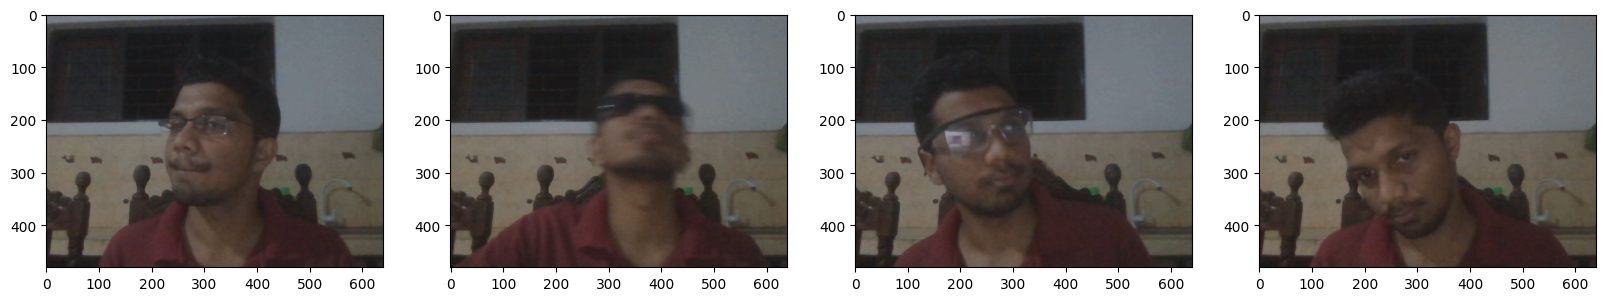

In [44]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [46]:
#splitting the data for train, validation and test
for folder in ['train','test','validation']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

In [47]:
#use albumentations to expand the dataset with different features

import albumentations as alb

In [48]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                         bbox_params=alb.BboxParams(format = 'albumentations', label_fields=['class_labels']))

In [93]:
img_test = cv2.imread(os.path.join('data','train','images','f121f168-0d57-11ee-a048-f6ac67e23db7.jpg'))
img_test

array([[[133, 122, 118],
        [132, 121, 117],
        [132, 121, 117],
        ...,
        [113, 109, 104],
        [114, 111, 103],
        [115, 112, 104]],

       [[134, 123, 119],
        [133, 122, 118],
        [132, 121, 117],
        ...,
        [113, 109, 104],
        [114, 111, 103],
        [114, 111, 103]],

       [[132, 123, 119],
        [131, 122, 118],
        [131, 122, 118],
        ...,
        [115, 109, 104],
        [114, 108, 103],
        [114, 108, 103]],

       ...,

       [[ 30,  32,  42],
        [ 29,  31,  41],
        [ 29,  31,  41],
        ...,
        [ 39,  41,  42],
        [ 42,  42,  42],
        [ 43,  43,  43]],

       [[ 28,  31,  39],
        [ 28,  31,  39],
        [ 28,  31,  39],
        ...,
        [ 39,  41,  42],
        [ 39,  41,  41],
        [ 40,  42,  42]],

       [[ 27,  31,  36],
        [ 28,  32,  37],
        [ 28,  31,  39],
        ...,
        [ 39,  41,  42],
        [ 39,  41,  41],
        [ 39,  41,  41]]

In [94]:
#opening a lable file
with open(os.path.join('data','train','labels','f121f168-0d57-11ee-a048-f6ac67e23db7.json'),'r') as f:
    label = json.load(f)

In [95]:
label['shapes'][0]

{'label': 'face',
 'points': [[217.77227722772278, 75.64356435643565],
  [423.2178217821782, 380.5940594059406]],
 'group_id': None,
 'description': '',
 'shape_type': 'rectangle',
 'flags': {}}

In [96]:
#extracting coordinates of the bounding box

coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [98]:
coords = list(np.divide(coords,[640,480,640,480]))   #normalizing
coords

[0.34026918316831684,
 0.1575907590759076,
 0.6612778465346534,
 0.7929042904290429]

In [99]:
#applying augmentation
augmented = augmentor(image =img_test, bboxes=[coords], class_labels = ['face'])

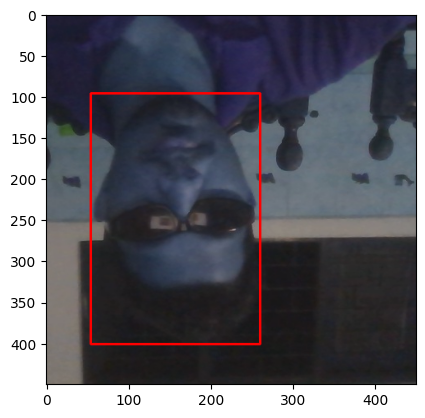

In [100]:
#visualizing the bounding box
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2],[450,450]).astype(int)),  #starting pointsw of the bouding box giving as a tuple since cv2 requires
              tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype(int)),
              (255,0,0),2) #rgb (actually it reads as bgr) parameters & thickness

plt.imshow(augmented['image'])


In [102]:
#run augmentation pipeline

for partition in ['train','test','validation']:                                                                     #looping through the folders
    for image in os.listdir(os.path.join('data', partition, 'images')):                                      #
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]                                                                       #seting a default annotations if there is none(pictures that dont have face on it)
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]                                                  #extracting coordinates as before
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):                                                                             #create 60 augmented images per one image (90*60 images in total)
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])  #saving augemented images

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]                                                          #seting a default annotations if there is none(pictures that dont have face on it)
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.6605043316831682, 0.16996699669966997, 0.3534189356435643, 0.8712871287128714, 'face'].


In [105]:
#loading the data to the tensorflow dataset

train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle = False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))                        #rescaling the images for more efficeiency
train_images = train_images.map(lambda x: x/255)                                                 #normalizing the pixels

In [117]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle = False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))                        
test_images = test_images.map(lambda x: x/255)

In [118]:
validation_images = tf.data.Dataset.list_files('aug_data\\validation\\images\\*.jpg', shuffle = False)
validation_images = validation_images.map(load_image)
validation_images = validation_images.map(lambda x: tf.image.resize(x, (120,120)))                        
validation_images = validation_images.map(lambda x: x/255)

In [119]:
train_images.as_numpy_iterator().next()

array([[[0.5112745 , 0.47990197, 0.43676472],
        [0.52322304, 0.48658088, 0.44607842],
        [0.5183211 , 0.48694852, 0.44381127],
        ...,
        [0.25245097, 0.15833333, 0.15833333],
        [0.25900736, 0.15704657, 0.15349264],
        [0.24754901, 0.14558823, 0.14656863]],

       [[0.5147059 , 0.48468137, 0.44675246],
        [0.5302696 , 0.49503675, 0.45833334],
        [0.5328431 , 0.49362746, 0.44656864],
        ...,
        [0.25006127, 0.15545343, 0.15692402],
        [0.24356617, 0.14938726, 0.14957108],
        [0.2504902 , 0.15147059, 0.15392157]],

       [[0.5016544 , 0.47567403, 0.43351716],
        [0.52297795, 0.490625  , 0.44797793],
        [0.5293505 , 0.4901348 , 0.44307598],
        ...,
        [0.24705882, 0.14901961, 0.16078432],
        [0.23921569, 0.15294118, 0.16078432],
        [0.24221814, 0.15104167, 0.15398285]],

       ...,

       [[0.5076593 , 0.52726716, 0.54650736],
        [0.5079044 , 0.5284926 , 0.54601717],
        [0.49411765, 0

In [120]:
#prepare the labels

def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [122]:
#loading the labels to tensorflow dataset
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

validation_labels = tf.data.Dataset.list_files('aug_data\\validation\\labels\\*.json', shuffle=False)
validation_labels = validation_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [124]:
#checking the current dataset of images and labels
len(train_images), len(train_labels), len(test_images), len(test_labels), len(validation_images), len(validation_labels)

(3720, 3720, 840, 840, 780, 780)

In [125]:
#combining the images and labels datasets
train = tf.data.Dataset.zip((train_images, train_labels))       #zip method
train = train.shuffle(4000)                                     #shuffle number should be higher than the dataset value
train = train.batch(8)
train = train.prefetch(4)

In [126]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [127]:
val = tf.data.Dataset.zip((validation_images, validation_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [128]:
train.as_numpy_iterator().next()[1]


(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0]], dtype=uint8),
 array([[0.876 , 0.1511, 1.    , 0.8926],
        [0.4067, 0.2335, 0.8667, 0.8516],
        [0.4111, 0.1251, 0.8765, 0.8413],
        [0.1359, 0.1315, 0.6177, 0.751 ],
        [0.1344, 0.1327, 0.6494, 0.809 ],
        [0.3618, 0.1512, 0.8306, 0.866 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ]], dtype=float16))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


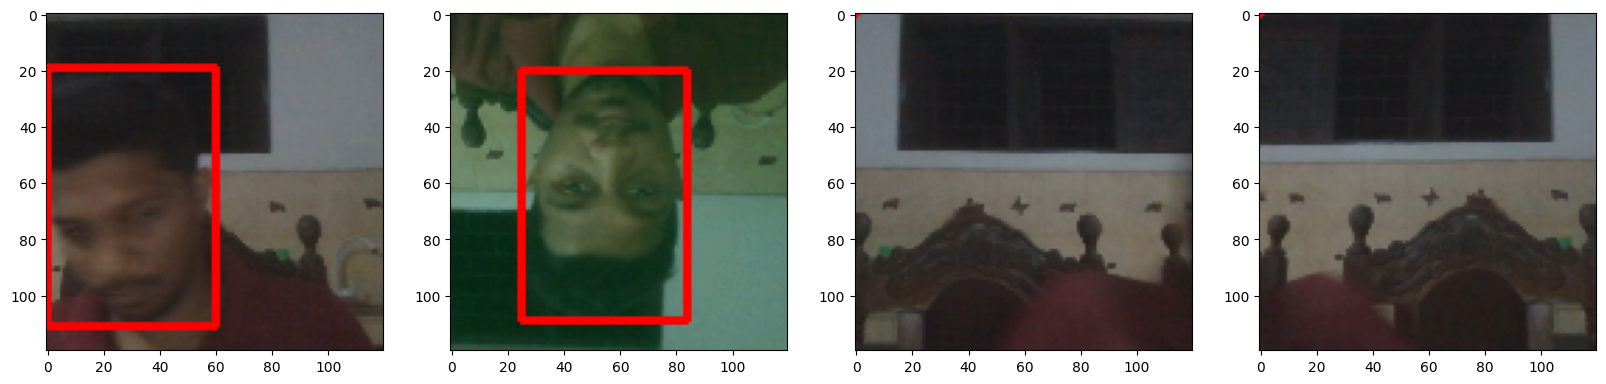

In [130]:
#checking the images
data_samples = train.as_numpy_iterator()
res = data_samples.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [134]:
#building the model 
#importing libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [158]:
tf.__version__

'2.12.0'

In [135]:
vgg = VGG16(include_top = False)
vgg.summary()

58889256/58889256 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [145]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)             #feed the VGG the input layer(VGG is a massive classification model)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)                          #use VGG ouput as the input for the hidden layers
    class_layer1 = Dense(2048, activation='relu')(f1)
    class_layer2 = Dense(1, activation='sigmoid')(class_layer1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress_layer1 = Dense(2048, activation='relu')(f2)
    regress_layer2 = Dense(4, activation='sigmoid')(regress_layer1)
    
    OD_model = Model(inputs=input_layer, outputs=[class_layer2, regress_layer2])
    return OD_model

In [151]:
OD_model = build_model()

In [152]:
#optimizers and loss functionms
batches_per_epoch = len(train)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))                       #
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [153]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [154]:
#train the model
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [155]:
model = FaceTracker(OD_model)

In [156]:
model.compile(opt, classloss, regressloss)

In [160]:
hist = model.fit(train, epochs=3, validation_data=val)

Epoch 1/3
465/465 [==============================] - 1095s 2s/step - total_loss: 0.1166 - class_loss: 0.0167 - regress_loss: 0.1083 - val_total_loss: 0.0440 - val_class_loss: 4.7711e-04 - val_regress_loss: 0.0438
Epoch 2/3
465/465 [==============================] - 933s 2s/step - total_loss: 0.0163 - class_loss: 1.1862e-04 - regress_loss: 0.0162 - val_total_loss: 0.0102 - val_class_loss: 8.1737e-05 - val_regress_loss: 0.0101
Epoch 3/3
465/465 [==============================] - 862s 2s/step - total_loss: 0.0127 - class_loss: 4.6674e-05 - regress_loss: 0.0126 - val_total_loss: 0.0085 - val_class_loss: 4.4365e-05 - val_regress_loss: 0.0085


In [162]:
#testing predictions
test_data = test.as_numpy_iterator()
test_sample = test_data.next()

In [167]:
yhat = OD_model.predict(test_sample[0])

1/1 [==============================] - 3s 3s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


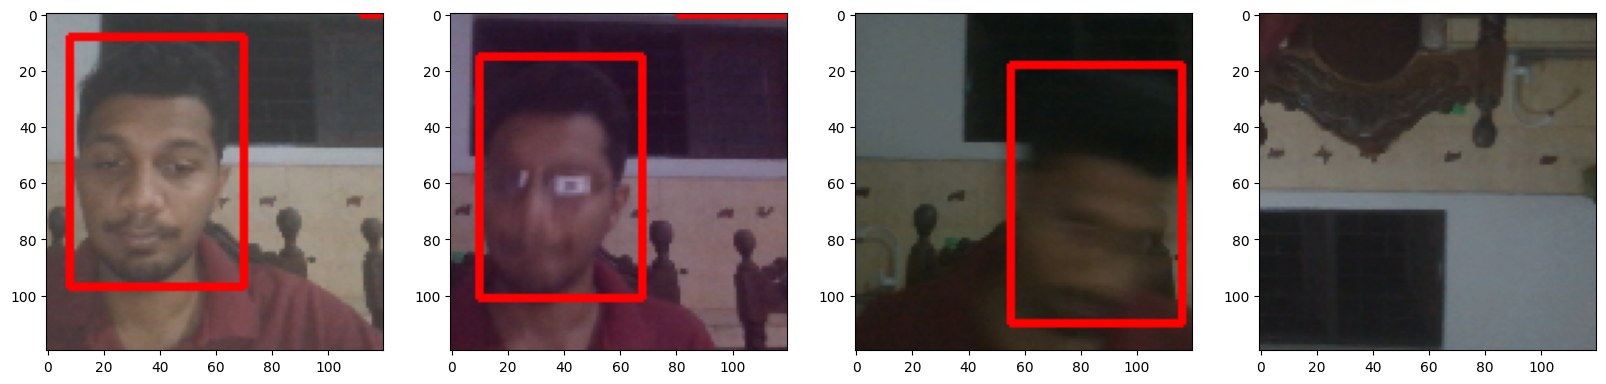

In [168]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.8:                  #draw the boundary if the probability is greater than the value
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [170]:
#real time detection

cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]                     
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)                                                      #converting the colors from BGR to RGB
    resized = tf.image.resize(rgb, (120,120))                                                         #resizing the frame
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 1s 1s/step


KeyboardInterrupt: 

: 